<a href="https://colab.research.google.com/github/AlexTitu/UC-Merced-Land-Use-ResNet/blob/main/UC_Merced_Land_Use_Augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn

In [ ]:
import os.path
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.nn import (Module, Conv2d, Linear, BatchNorm2d, Sequential, ReLU, MaxPool2d,
                      AdaptiveAvgPool2d, Dropout, AvgPool2d, CrossEntropyLoss)
import torch.nn.functional as F
import numpy as np
import torch
import time
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/UCMerced_LandUse
models_dir = './model_dir'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ZQVFrncUBriML0J_4bfVk7OoJAhg4M44/UCMerced_LandUse


In [ ]:
class BasicPolicy(object):
  def __init__(self, mirror_ratio=0, flip_ratio=0, color_change_ratio=0, is_full_set_colors=False, add_noise_peak=0.0, erase_ratio=-1.0):
    # Random color channel order
    from itertools import product, permutations
    self.indices = list(product([0, 1, 2], repeat = 3)) if is_full_set_colors else list(permutations(range(3), 3))
    self.indices.insert(0, [0, 1, 2])# R, G, B
    self.add_noise_peak = add_noise_peak

    # Mirror and flip
    self.color_change_ratio = color_change_ratio
    self.mirror_ratio = mirror_ratio
    self.flip_ratio = flip_ratio

    # erase
    self.erase_ratio = erase_ratio

  def __call__(self, img):
    # 0) Add poisson noise (e.g. choose peak value 20)
    # https://stackoverflow.com/questions/19289470/adding-poisson-noise-to-an-image
    if self.add_noise_peak > 0:
          PEAK = self.add_noise_peak
          img = np.random.poisson(np.clip(img, 0, 1) * PEAK) / PEAK

    # Color change
    policy_idx = random.randint(0,len(self.indices)-1)
    if random.uniform(0, 1) >= self.color_change_ratio:
      policy_idx = 0

    img = img[...,list(self.indices[policy_idx])]

    # Mirror image
    if random.uniform(0,1) <= self.mirror_ratio:
      img = img[...,::-1,:].copy()

    # Flip image vertically
    if random.uniform(0, 1) < self.flip_ratio:
      img = img[::-1,:,:].copy()

    # 4) Erase random box
    if random.uniform(0, 1) < self.erase_ratio:
      img = self.eraser(img)

    return img

  def __repr__(self):
    return "Basic Policy"

  def eraser(self, input_img, p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=True):
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
      return input_img

    while True:
      s = np.random.uniform(s_l, s_h) * img_h * img_w
      r = np.random.uniform(r_1, r_2)
      w = int(np.sqrt(s / r))
      h = int(np.sqrt(s * r))
      left = np.random.randint(0, img_w)
      top = np.random.randint(0, img_h)

      if left + w <= img_w and top + h <= img_h:
        break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img


In [ ]:
class UCMercedLandUseDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_flip=False, is_addnoise=False, is_erase=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        self.labels = []
        self.policy = BasicPolicy(color_change_ratio=0, mirror_ratio=0.50, flip_ratio=0.5 if not is_flip else 0.2,
                                  add_noise_peak=0 if not is_addnoise else 20, erase_ratio=-1.0 if not is_erase else 0.5)

        # Load dataset
        self.load_dataset()

    def load_dataset(self):
       # assuming classes are folders in the root_dir
       self.classes = sorted(os.listdir(self.root_dir))

       for class_index, class_name in enumerate(self.classes):
        class_dir = os.path.join(self.root_dir, class_name)
        if not os.path.isdir(class_dir):
          continue

        for image_name in os.listdir(class_dir):
          if image_name.lower().endswith(('png', 'jpg', 'jpeg', 'tif')):
            image_path = os.path.join(class_dir, image_name)
            self.images.append(image_path)
            self.labels.append(class_index)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, index, is_apply_policy=True):
      image_path = self.images[index]
      image =  np.clip(np.asarray(Image.open(image_path).convert('RGB'))/255,0,1)
      label = self.labels[index]

      if is_apply_policy: image = self.policy(image)

      if self.transform:
        image = self.transform(image)

      return image.float(), label


In [ ]:
# ensuring all images are same size and are stored in a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

# loading the dataset
dataset = UCMercedLandUseDataset(root_dir='./Images/', transform=transform, is_flip=True)

# getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] device used for training...{}".format(device))

# getting dataset dimension
print(f"[INFO] Number of data in the dataset...{len(dataset)}") # Dataset = 2100

[INFO] device used for training...cuda
[INFO] Number of data in the dataset...2100


In [ ]:
# ensuring even split of classes in train and test sets
def stratified_split(dataset, test_size=0.2, validation_size=0.1, random_state=None):
  # Assuming 'dataset.labels' contains your labels
  labels = dataset.labels

  # Create stratified split for test set
  train_index, test_index = train_test_split(
      range(len(labels)),
      test_size=test_size,
      random_state=random_state,
      stratify=labels)

  # Adjust validation size based on remaining data after test split
  adjusted_validation_size = validation_size / (1 - test_size)

  # Create stratified split for validation and train sets
  train_index, val_index = train_test_split(
      train_index,
      test_size=adjusted_validation_size,
      random_state=random_state,
      stratify=[labels[i] for i in train_index])

  return train_index, val_index, test_index

In [ ]:
# define training hyperparameters
INIT_LR = 1*1e-3
BATCH_SIZE = 6
EPOCHS = 80

tensor(0)
Number of training samples: 1470 / Number of val samples: 210 / Number of val samples: 420 


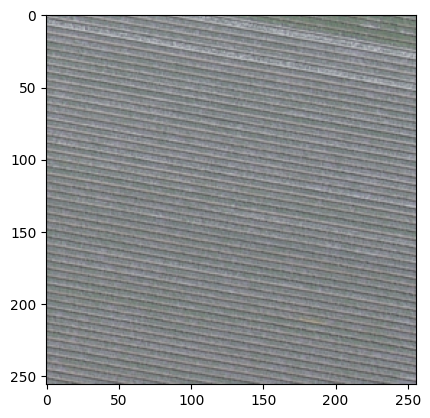

In [ ]:
# visualizing and image from the set
train_index, val_index, test_index = stratified_split(dataset, random_state=19)

train_dataset = Subset(dataset, train_index)
val_dataset = Subset(dataset, val_index)
test_dataset = Subset(dataset, test_index)

trainDataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

for image, label in trainDataLoader:
  plt.imshow(image[0].permute(1,2,0))
  print(label[0])
  break

print(f'Number of training samples: {len(train_dataset)} / Number of val samples: {len(val_dataset)} / Number of val samples: {len(test_dataset)} ')

In [ ]:
# calculate steps per epoch for training, validation set
trainSteps = len(trainDataLoader.dataset)//BATCH_SIZE
valSteps = len(valDataLoader.dataset)//BATCH_SIZE
testSteps = len(testDataLoader.dataset)//BATCH_SIZE

print(f"Number of steps (train/val/test): {trainSteps}, {valSteps}, {testSteps}")

Number of steps (train/val/test): 245, 35, 70


#Model

In [ ]:
class Bottleneck (Module):
    def __init__(self, in_channels, intermediate_channels, expansion, is_Bottleneck, stride):
        """
        Creates a Bottleneck with conv 1x1->3x3->1x1 layers.

        Note:
            1. Addition of feature maps occur at just before the final ReLU with the input feature maps
            2. if input size is different from output, select projected mapping or else identity mapping.
            3. if is_Bottleneck=False (3x3->3x3) are used else (1x1->3x3->1x1). Bottleneck is required for resnet-50/101/152
        Args:
            in_channels (int) : input channels to the Bottleneck
            intermediate_channels (int) : number of channels to 3x3 conv
            expansion (int) : factor by which the input #channels are increased
            stride (int) : stride applied in the 3x3 conv. 2 for first Bottleneck of the block and 1 for remaining

        Attributes:
            Layer consisting of conv->batchnorm->relu
        """

        super(Bottleneck, self).__init__()

        self.expansion = expansion
        self.in_channels = in_channels
        self.intermediate_channels = intermediate_channels
        self.is_Bottleneck = is_Bottleneck

        # i.e. if dim(x) == dim(F) => identity function
        if self.in_channels == self.intermediate_channels * self.expansion:
            self.identity = True

        else:
            self.identity = False
            downsample_layer = [
                Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels * self.expansion,
                       kernel_size=1, stride=stride, padding=0, bias=False),
                BatchNorm2d(self.intermediate_channels * self.expansion)]
            # Only conv -> BN and no ReLU
            # projection layer.append(ReLU())
            self.downsample= Sequential(*downsample_layer)

        self.relu = ReLU()

        # is_Bottleneck = True for all ResNet50+
        if self.is_Bottleneck:
            # bottleneck
            # 1x1
            self.conv1 = Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=1,
                                    stride=1, padding=0, bias=False)
            self.bn1 = BatchNorm2d(self.intermediate_channels)

            # 3x3
            self.conv2 = Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels,
                                    kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn2 = BatchNorm2d(self.intermediate_channels)

            # 1x1
            self.conv3 = Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels*self.expansion,
                                    kernel_size=1, stride=1, padding=0, bias=False)
            self.bn3 = BatchNorm2d(self.intermediate_channels*self.expansion)

        else:
            # basicblock
            # 3x3
            self.conv1 = Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=3,
                                    stride=stride, padding=1, bias=False)
            self.bn1 = BatchNorm2d(self.intermediate_channels)

            # 3x3
            self.conv2 = Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels,
                                    kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = BatchNorm2d(self.intermediate_channels)

    def forward(self, x):
        # input stored to be added before final ReLU - skip connection
        in_x = x

        if self.is_Bottleneck:
            # conv1x1->BN->ReLU
            x = self.relu(self.bn1(self.conv1(x)))

            # conv3x3->BN->ReLU
            x = self.relu(self.bn2(self.conv2(x)))

            # conv1x1->BN
            x = self.bn3(self.conv3(x))

        else:
            # conv3x3->BN->ReLU
            x = self.relu(self.bn1(self.conv1(x)))

            #conv3x3->BN
            x = self.bn2(self.conv2(x))

        if self.identity:
            x += in_x
        else:
            x += self.downsample(in_x)

        # final ReLU
        x = self.relu(x)

        return x


class ResNet(Module):
    def __init__(self, resnet_variant, in_channels, num_classes=None, feature_extractor=False):
        """
        Creates the ResNet architecture based on the provided variant. 18/34/50/101 etc.
        Based on the input parameters, define the channels list, repetition list along with expansion factor(4) and stride(3/1)
        using _make_blocks method, create a sequence of multiple Bottlenecks
        Average Pool at the end before the FC layer

        Args:
            resnet_variant (list) : e.g. [[64,128,256,512],[3,4,6,3],4,True]
            in_channels (int) : image channels (3)
            num_classes (int) : output #classes

        Attributes:
            Layer consisting of conv->batchnorm->relu

        """

        super(ResNet, self).__init__()
        print(f"[INFO] initializing the ResNet model...")
        self.channel_list = resnet_variant[0]
        self.repetition_list = resnet_variant[1]
        self.expansion = resnet_variant[2]
        self.is_Bottleneck = resnet_variant[3]
        self.feature_extractor = feature_extractor

        if not self.feature_extractor and num_classes is None:
            raise ValueError(f"num_classes must be of type integer, got None instead.")

        self.conv1 = Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = BatchNorm2d(64)
        self.relu = ReLU()

        self.maxpool = MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_blocks(64, self.channel_list[0], self.repetition_list[0], self.expansion,
                                        self.is_Bottleneck, stride=1)
        self.layer2 = self._make_blocks(self.channel_list[0]*self.expansion, self.channel_list[1], self.repetition_list[1],
                                        self.expansion, self.is_Bottleneck, stride=2)
        self.layer3 = self._make_blocks(self.channel_list[1]*self.expansion, self.channel_list[2], self.repetition_list[2],
                                        self.expansion, self.is_Bottleneck, stride=2)
        self.layer4 = self._make_blocks(self.channel_list[2]*self.expansion, self.channel_list[3], self.repetition_list[3],
                                        self.expansion, self.is_Bottleneck, stride=2)

        if not self.feature_extractor:
            self.average_pool = AdaptiveAvgPool2d(1)
            self.fc1 = Linear(self.channel_list[3]*self.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if not self.feature_extractor:
            x = self.average_pool(x)
            x = torch.flatten(x, start_dim=1)
            x = self.fc1(x)

        return x

    def _make_blocks(self, in_channels, intermediate_channels, num_repeat, expansion, is_Bottleneck, stride):
        """
        Args:
            in_channels : #channels of the Bottleneck input
            intermediate_channels : #channels of the 3x3 in the Bottleneck
            num_repeat : #Bottlenecks in the block
            expansion : factor by which intermediate_channels are multiplied to create the output channels
            is_Bottleneck : status if Bottleneck in required
            stride : stride to be used in the first Bottleneck conv 3x3

        Attributes:
            Sequence of Bottleneck layers

        """

        layers = [Bottleneck(in_channels, intermediate_channels, expansion, is_Bottleneck, stride=stride)]

        for num in range(1, num_repeat):
            layers.append(Bottleneck(intermediate_channels*expansion, intermediate_channels, expansion, is_Bottleneck,
                                     stride=1))

        return Sequential(*layers)

# Early Stopping function

In [ ]:
# defining Early Stopping class
class EarlyStopping():
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf
    self.best_epoch = 0
    self.best_train = None
    self.best_val = None

  def earlyStop(self, epoch, trainLoss, valLoss, model):
    if valLoss <= (self.min_validation_loss + self.min_delta):
      print("[INFO] In EPOCH {} the loss value improved from {:.5f} to {:.5f}".format(epoch, self.min_validation_loss, valLoss))
      self.setMinValLoss(valLoss)
      self.setCounter(0)
      self.setBestEpoch(epoch)
      torch.save(model.state_dict(), f"{models_dir}/ResNet18_state_dict_test_val_02.pt")
      self.setBestLosses(trainLoss, valLoss)

    elif valLoss > (self.min_validation_loss + self.min_delta):
      self.setCounter(self.counter + 1)
      print("[INFO] In EPOCH {} the loss value did not improve from {:.5f}. This is the {} EPOCH in a row.".format(epoch, self.min_validation_loss, self.counter))
      if self.counter >= self.patience:
        return True
    return False

  def setCounter(self, counter_state):
    self.counter = counter_state

  def setMinValLoss(self, ValLoss):
    self.min_validation_loss = ValLoss

  def setBestLosses(self, trainLoss, valLoss):
    self.best_train = trainLoss
    self.best_val = valLoss

  def setBestEpoch(self, bestEpoch):
    self.best_epoch = bestEpoch

  def getBestTrainLoss(self):
    return self.best_train

  def getBestValLoss(self):
    return self.best_val

  def getBestEpoch(self):
    return self.best_epoch

  def saveLossesLocally(self):
    np.save(f'{models_dir}/losses_train_18test_val_02.npy', np.array(self.best_train))
    np.save(f'{models_dir}/losses_val_18test_val_02.npy', np.array(self.best_val))

  def loadLossesLocally(self):
    self.best_train = np.load(f'{models_dir}/losses_train_18test_val_02.npy')
    self.best_val = np.load(f'{models_dir}/losses_val_18test_val_02.npy')

#Training loop

In [ ]:
# defining possible resnet models
model_parameters = {'resnet18': [[64, 128, 256, 512], [2, 2, 2, 2], 1, False],
                    'resnet34': [[64, 128, 256, 512], [3, 4, 6, 3], 1, False],
                    'resnet50': [[64, 128, 256, 512], [3, 4, 6, 3], 4, True],
                    'resnet101': [[64, 128, 256, 512], [3, 4, 23, 3], 4, True],
                    'resnet152': [[64, 128, 256, 512], [3, 8, 36, 3], 4, True]}

# load from drive previous results
# previous_state = torch.load(f"{models_dir}/train_state_dict.pt")
# previous_model = torch.load(f"{models_dir}/ResNet18_state_dict_Val.pt")

# loading ResNet34
model = ResNet(model_parameters['resnet18'], 3, 21, False).to(device)
# model.load_state_dict(previous_state['model_state_dict'])

# model.load_state_dict(previous_model)

from torchvision.models import resnet18
pretrained_resnet18 = resnet18(weights='IMAGENET1K_V1')
pretrained_state_dict = pretrained_resnet18.state_dict()

# loading pretrained weights
model.load_state_dict(pretrained_state_dict, strict=False)

# initializing optimizer and lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)
# optimizer.load_state_dict(previous_state['optimizer_state_dict'])

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# initializing loss function
lossFn = CrossEntropyLoss()

# optimizing only after a certain number of batches
accumulation_steps = 4


H = {
  "total_train_loss": [],
  "total_val_loss":[],
  "time":[]
}

# load previous loss history and last epoch
# H = previous_state['train_loss_history']
# last_epoch = previous_state['epoch']+1

print("[INFO] training the network...")

[INFO] initializing the ResNet model...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


[INFO] training the network...


In [ ]:
early_stopper = EarlyStopping(patience=5)
startTime = time.time()
H["time"].append(startTime)

for e in range(EPOCHS):
  # set the model to training mode
  model.train()

  total_train_loss = 0
  total_val_loss = 0

  for step, (images, gt_labels) in enumerate(trainDataLoader):
    # forward pass
    images = images.to(device)
    gt_labels = gt_labels.to(device)

    pred_labels = model(images)

    loss = lossFn(pred_labels, gt_labels) / accumulation_steps
    loss.backward()

    # we will apply weights optimization every 3 batches for more stable gradients
    # 4 batches x 6 images/batch = 24 data passes
    if step + 1 != 1:
      if (accumulation_steps % (step + 1) == 0) or (trainSteps % (step + 1) != 0 and trainSteps == (step + 1)):
        optimizer.step()
        optimizer.zero_grad()
        # print(f"Train loss at {step+1} is: {(train_loss+loss.cpu().detach().numpy())/step+1}")

    total_train_loss += loss.cpu().detach().numpy()


  with torch.no_grad():
    model.eval()

    for images, gt_labels in valDataLoader:
      images = images.to(device)
      gt_labels = gt_labels.to(device)

      pred_labels = model(images)

      loss = lossFn(pred_labels, gt_labels)

      total_val_loss += loss.cpu().detach().numpy()


  # calculate the average training and validation loss
  avgTrainLoss = total_train_loss / trainSteps
  avgValLoss = total_val_loss / valSteps

  # Adding another step through an epoch to the scheduler
  scheduler.step(avgValLoss)

  # Saving training and evaluation history
  H['total_train_loss'].append(avgTrainLoss)
  H['total_val_loss'].append(avgValLoss)
  H['time'].append(time.time())
  # saving current state dicts of the epoch and loss history - checkpoint
  torch.save({
    'epoch': e,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_history': H
  }, f"{models_dir}/train_state_dict_18_test_val_02.pt")

  # print the model training and validation information
  print("[INFO]: EPOCH: {}/{}...".format(e+1, EPOCHS))
  print("Train loss: {:.5f}".format(avgTrainLoss))
  print("Validation loss: {:.5f}".format(avgValLoss))
  # checking if resulting loss in evaluation improved
  if early_stopper.earlyStop((e+1), avgTrainLoss, avgValLoss, model):
    # if not improved - stop the training
    print("[INFO] Early Stopping the train process. Patience exceeded!")
    print("=============================================================")
    break

  print("=============================================================")

# finishing the training and calculating train time
endTime = time.time()
print("[INFO] Total time taken to train the model: {:.2f}s".format(endTime-startTime))
print("[INFO] Best loss was found in Epoch {} where the performance was {:.5f}. "
      "Model's parameters saved!".format(early_stopper.getBestEpoch(), early_stopper.getBestValLoss()))

early_stopper.saveLossesLocally()

[INFO]: EPOCH: 1/80...
Train loss: 0.64444
Validation loss: 2.53068
[INFO] In EPOCH 1 the loss value improved from inf to 2.53068
[INFO]: EPOCH: 2/80...
Train loss: 0.45516
Validation loss: 1.55105
[INFO] In EPOCH 2 the loss value improved from 2.53068 to 1.55105
[INFO]: EPOCH: 3/80...
Train loss: 0.35009
Validation loss: 1.00821
[INFO] In EPOCH 3 the loss value improved from 1.55105 to 1.00821
[INFO]: EPOCH: 4/80...
Train loss: 0.26524
Validation loss: 0.71169
[INFO] In EPOCH 4 the loss value improved from 1.00821 to 0.71169
[INFO]: EPOCH: 5/80...
Train loss: 0.18367
Validation loss: 0.39790
[INFO] In EPOCH 5 the loss value improved from 0.71169 to 0.39790
[INFO]: EPOCH: 6/80...
Train loss: 0.14482
Validation loss: 0.31248
[INFO] In EPOCH 6 the loss value improved from 0.39790 to 0.31248
[INFO]: EPOCH: 7/80...
Train loss: 0.11635
Validation loss: 0.20953
[INFO] In EPOCH 7 the loss value improved from 0.31248 to 0.20953
[INFO]: EPOCH: 8/80...
Train loss: 0.09707
Validation loss: 0.1524

In [ ]:
# switching off autograd for eval
test_true_labels = []
test_pred_labels = []
H['total_test_loss'] = []

with torch.no_grad():
  # set the model in eval mode
  model.eval()

  for images, gt_labels in testDataLoader:
    images = images.to(device)
    gt_labels = gt_labels.to(device)

    pred_labels = model(images)
    loss = lossFn(pred_labels, gt_labels)
    H['total_test_loss'].append(loss.cpu().detach().tolist())
    test_true_labels.extend(gt_labels.cpu().detach().tolist())
    test_pred_labels.extend(pred_labels.cpu().detach().tolist())

  totalTestLoss = np.array(H['total_test_loss'])

  print(f"Cross Entropy on test:{np.sum(totalTestLoss)/testSteps}")




Cross Entropy on test:0.06267584571355006


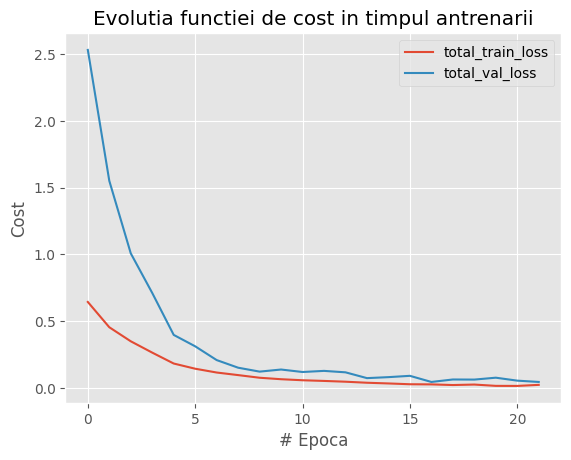

In [ ]:
# plot the training and val losses
plt.style.use("ggplot")

# Plotting magnitude loss on train and evaluation
plt.figure("magnitude_loss").clear()
plt.plot(H["total_train_loss"], label="total_train_loss", linestyle="solid")
plt.plot(H["total_val_loss"], label="total_val_loss", linestyle="solid")
plt.title("Evolutia functiei de cost in timpul antrenarii")
plt.xlabel("# Epoca")
plt.ylabel("Cost")
plt.legend(loc="upper right")
plt.savefig(f"{models_dir}/4_4_val_test.png")

(420,)
(420,)
                   precision    recall  f1-score   support

     agricultural       1.00      0.95      0.97        20
         airplane       1.00      1.00      1.00        20
  baseballdiamond       1.00      1.00      1.00        20
            beach       1.00      1.00      1.00        20
        buildings       0.95      1.00      0.98        20
        chaparral       1.00      1.00      1.00        20
 denseresidential       0.83      0.95      0.88        20
           forest       1.00      1.00      1.00        20
          freeway       1.00      1.00      1.00        20
       golfcourse       1.00      1.00      1.00        20
           harbor       1.00      1.00      1.00        20
     intersection       1.00      1.00      1.00        20
mediumresidential       1.00      0.75      0.86        20
   mobilehomepark       1.00      1.00      1.00        20
         overpass       1.00      1.00      1.00        20
       parkinglot       1.00      1.00   

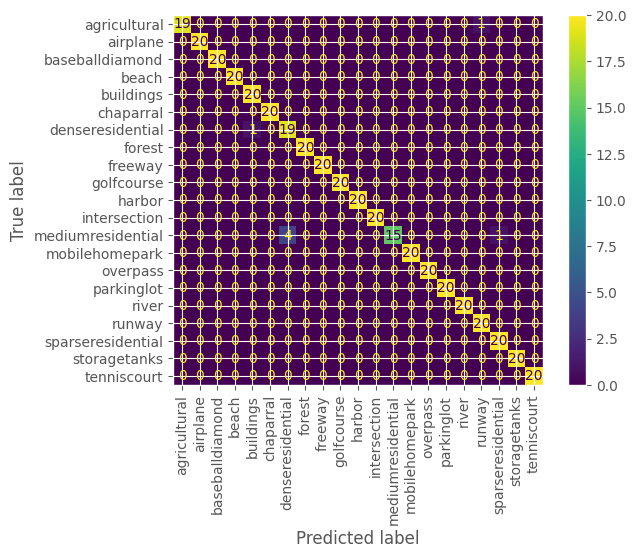

In [ ]:
float_true = np.array(test_true_labels, dtype=float)
float_pred = np.zeros(len(test_pred_labels), dtype=float)

for i in range(len(test_pred_labels)):
  float_pred[i] = np.argmax(test_pred_labels[i])

print(float_true.shape)
print(float_pred.shape)
print(classification_report(float_true, float_pred, labels=range(0,21), target_names=dataset.classes))

confusionMatrix = confusion_matrix(float_true, float_pred, labels=range(0,21))


displayConfusion = ConfusionMatrixDisplay(confusionMatrix, display_labels=dataset.classes)

displayConfusion.plot(xticks_rotation=90)

plt.savefig('confusion34_ext.png')

# print(float_pred)
# print(float_true)
# print(lossFn(torch.tensor(float_true), torch.tensor(float_pred))/len(float_pred))